# **Instructions**

This document is a template, and you are not required to follow it exactly. However, the kinds of questions we ask here are the kinds of questions we want you to focus on. While you might have answered similar questions to these in your project presentations, we want you to go into a lot more detail in this write-up; you can refer to the Lab homeworks for ideas on how to present your data or results. 

You don't have to answer every question in this template, but you should answer roughly this many questions. Your answers to such questions should be paragraph-length, not just a bullet point. You likely still have questions of your own -- that's okay! We want you to convey what you've learned, how you've learned it, and demonstrate that the content from the course has influenced how you've thought about this project.

# Defending Adversarial Attacks
Project mentor: Mark Dredze

Xuan Wu	<xwu71@jhu.edu> Yunxiao Yang <yyang117@jhu.edu>
Chenyu Zhang <czhan105@jhu.edu>		Jinhan Zhang <jzhan205@jhu.edu>				

Link to github repo: https://github.com/ChenyuHeidiZhang/cs475_ml_project

# Outline and Deliverables


### Uncompleted Deliverables
1. "Expect to accomplish #1": we decided to focus only on the support vector machine (SVM) and thus did not repeat the experiment with convolutional neural network (CNN) 


### Completed Deliverables
1.  "Must accomplish #1": (Dataset section) Obtain and inspect the digits dataset.

2.  "Must accomplish #2": (Methods section 1) Perform PCA on training data.

3. "Must accomplish #3": (Baseline section) Attack the data by adversarial examples generated using the ART toolbox. Check accuracy and compare with the baseline. Explore various attackers.

4.  "Expect to accomplish #2": (Methods section 4) Develop a robust training algorithm adapted from the idea of feedback learning.

5.  "Expect to accomplish #3": (Results section) Evaluate the performance of the models against baseline.


### Additional Deliverables
1. (Methods section 2) Sharpening the data. 

2. (Methods section 3) Data Augmentation methods for adversarial training.

# Preliminaries

## What problem were you trying to solve or understand?



### What are the real-world implications of this data and task?
We chose robustness as the theme of our project because it is a prevalent problem that all models might face. A robust machine learning model is defined to be one that
performs reasonably well even when the dataset (training set or testing set or both) is perturbed. It is legitimate problem since real-world data can be noisy and not as representative as the classic datasets, like Iris or MNIST. As more high-stakes applications begin to utilize ML, it has never been more critical to build robust models that ensure fairness and safety.

### How is this problem similar to others we’ve seen in lectures, breakouts, and homeworks?


### What makes this problem unique?


### What ethical implications does this problem have?
A not robust model is prone to be erroneous when data is not as nice as expected, and this can be a huge problem as ML gaining popularities in fields like autonomous vehicle and precision medicine.


## Dataset(s)

Describe the dataset(s) you used.

How were they collected?


Why did you choose them?

How many examples in each?


Answer:

We used multi-class, grey-scale, hand-written digit dataset from Scikit-learn library. The data is 
adapted from the 
test set of Optical Recognition of Handwritten 
Digits Data. 

The dataset contains 1797 instances of hand-written digits, where each instance is an image of 
size eight by eight (thus a total of 64 pixels).
 For each pixel, the valid range of value is 
 an integer between 0 to 16. There are ten 
 digits classes, and each class contains ~ 
 180 pictures; thus, the digit dataset is a well-balanced dataset. This dataset does not 
 provide an underlying train-test split, so 
 we did a 80-20 split ourselves.

We chose this classic dataset because we are working on a theory project where the focus is to understand and defend adversarial attacks. This dataset allows us to introduce adversarial attack and observe an obvious decrease in accuracy.


1797 instances and 64 features


<Figure size 432x288 with 0 Axes>

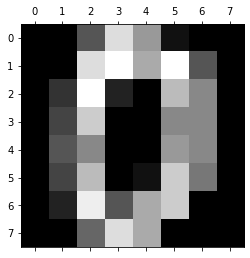

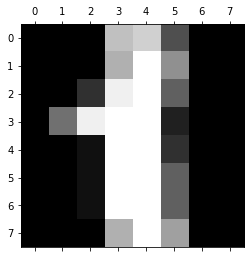

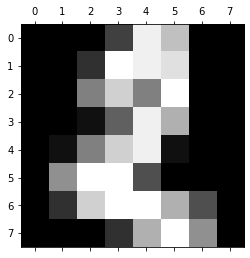

In [2]:
# Load your data and print 2-3 examples
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.datasets import load_digits
digits = load_digits()

print(f"{digits.data.shape[0]} instances and {digits.data.shape[1]} features")
plt.gray()
for i in range(3):
  plt.matshow(digits.images[i])

## Pre-processing

What features did you use or choose not to use? Why?

If you have categorical labels, were your datasets class-balanced?

How did you deal with missing data? What about outliers?

What approach(es) did you use to pre-process your data? Why?

Are your features continuous or categorical? How do you treat these features differently?

Answer:

The digits dataset from sklearn is quite clean and balanced. There is no missing data. It was already pre-processed with
normalization and dimension reduction. Therefore, we don't perform additional pre-processing steps, except for using PCA as a defense against adversarial examples in the methods section.


# Models and Evaluation

## Experimental Setup

How did you evaluate your methods? Why is that a reasonable evaluation metric for the task?

What did you use for your loss function to train your models? Did you try multiple loss functions? Why or why not?

How did you split your data into train and test sets? Why?


Answer:

Here we split the data into training and test. The digits dataset contains labels so we can evaluate on our test split. 

We use the SVM model, where the loss function is hinge loss.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, stratify=digits.target)
nb_classes = np.unique(y_train).shape[0]
print(np.unique(y_train))
print(X_train.shape, X_test.shape)

[0 1 2 3 4 5 6 7 8 9]
(1437, 64) (360, 64)


## Baselines 

What baselines did you compare against? Why are these reasonable?

Did you look at related work to contextualize how others methods or baselines have performed on this dataset/task? If so, how did those methods do?

In [4]:
# Download ART
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 890kB 12.0MB/s 
     |████████████████████████████████| 235kB 22.2MB/s 
     |████████████████████████████████| 21.0MB 7.5MB/s 
     |████████████████████████████████| 747kB 38.0MB/s 


In [5]:
from sklearn.svm import SVC
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import SklearnClassifier

#### Baseline model 1: train, test data both intact

In [6]:
baseline1 = SVC(C=1.0, kernel="rbf").fit(X_train, y_train)

predictions = baseline1.predict(X_test)
accuracy1 = np.sum(predictions == y_test) / len(y_test)
print("Accuracy for unperturbed data: {:.2f}%".format(accuracy1 * 100))

Accuracy for unperturbed data: 99.72%


#### Baseline model 2: train data intact, test perturbed
#### Baseline model 3: train data perturbed, test intact

In [7]:
# Create the ART classifier
min_pixel_value = np.amin(X_train)
max_pixel_value = np.amax(X_train)
classifier = SklearnClassifier(model=baseline1, clip_values=(min_pixel_value, max_pixel_value))

In [8]:
# Conduct Fast Gradient Attack on X with strengh epsilon
def fgAttack(X, epsilon):
    attack = FastGradientMethod(estimator=classifier, eps=epsilon)
    X_adv = attack.generate(x=X)
    return X_adv

# Generate adversarial test examples
X_test_adv = fgAttack(X_test, 3)

# Generate adversarial train examples
X_train_adv = fgAttack(X_train, 3)

In [9]:
# Baseline Accuracy 2: evaluate the original model on adversarial test examples
predictions = baseline1.predict(X_test_adv)
accuracy2 = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on adversarial test examples: {:.2f}%".format(accuracy2 * 100))

Accuracy on adversarial test examples: 56.39%


In [10]:
# Baseline Accuracy 3: train model with adversarial examples
baseline3 = SVC(C=1.0, kernel="rbf").fit(X_train_adv, y_train)
predictions = baseline3.predict(X_test)
accuracy3 = np.sum(predictions == y_test) / len(y_test)
print("Accuracy with adversarial training examples: {:.2f}%".format(accuracy3 * 100))

Accuracy with adversarial training examples: 65.83%


## Methods

What methods did you choose? Why did you choose them?

How did you train these methods, and how did you evaluate them? Why?

Which methods were easy/difficult to implement and train? Why?

For each method, what hyperparameters did you evaluate? How sensitive was your model's performance to different hyperparameter settings?

Answer:

We used four methods as different ways to defend adversarial attacks: PCA, data sharpening, data augmentation, and iterative learning. These methods are able to perform defenses in different ways to increase model robustness. The following sections describe them in detail.

### Data Transformation (PCA)

In [11]:
from sklearn.decomposition import PCA

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437,), (360,))

#### Baseline -- No perturbation on train/test with PCA

In [13]:
pca = PCA(n_components=25)
pca.fit(X_train)
pca_X_train = pca.transform(X_train)
pca_X_test = pca.transform(X_test)

model = SVC(C=1.0, kernel="rbf").fit(pca_X_train, y_train)
y_pred = model.predict(pca_X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Accuracy on PCA intact-test examples: {:.2f}%".format(accuracy * 100))

Accuracy on PCA intact-test examples: 99.72%


#### Baseline -- PCA then perturbation on train/test

In [14]:
pca = PCA(n_components=20)
pca.fit(X_train)
X_test_adv = fgAttack(X_test, 3)
pca_X_train = pca.transform(X_train)
pca_X_test = pca.transform(X_test_adv)
model = SVC(C=1.0, kernel="rbf").fit(pca_X_train, y_train)
y_pred = model.predict(pca_X_test)
accuracy_pca_test = np.sum(y_pred == y_test) / len(y_test)
print("Accuracy on PCA-then-perturbed-test examples: {:.2f}%".format(accuracy_pca_test * 100))

X_train_adv = fgAttack(X_train, 3)
pca_X_train = pca.transform(X_train_adv)
pca_X_test = pca.transform(X_test)
model = SVC(C=1.0, kernel="rbf").fit(pca_X_train, y_train)
y_pred = model.predict(pca_X_test)
accuracy_pca_train = np.sum(y_pred == y_test) / len(y_test)
print("Accuracy on PCA-then-perturbed-train examples: {:.2f}%".format(accuracy_pca_train * 100))

Accuracy on PCA-then-perturbed-test examples: 57.78%
Accuracy on PCA-then-perturbed-train examples: 58.89%


#### PCA AFTER ATTACK

In [15]:
pca = PCA(n_components=20)
pca.fit(X_train)
pca_X_train = pca.transform(X_train)
pca_X_test = pca.transform(X_test_adv)

model = SVC(C=1.0, kernel="rbf").fit(pca_X_train, y_train)
predictions = model.predict(pca_X_test)
accuracy_test_PCA = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on adversarial-test-then-PCA examples: {:.2f}%".format(accuracy_test_PCA * 100))

Accuracy on adversarial-test-then-PCA examples: 58.61%


In [16]:
pca = PCA(n_components=20)
pca.fit(X_train_adv)
pca_X_train = pca.transform(X_train_adv)
pca_X_test = pca.transform(X_test)

model = SVC(C=1.0, kernel="rbf").fit(pca_X_train, y_train)
predictions = model.predict(pca_X_test)
accuracy_train_PCA = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on adversarial-train-then-PCA examples: {:.2f}%".format(accuracy_train_PCA * 100))

Accuracy on adversarial-train-then-PCA examples: 78.89%


According to the literature, PCA can protect against adversarial attacks. PCA can remove the features (principal axes) with low variance, which has high coefficients and thus are targeted by adversarial attack methods. These methods aim to use the minimum amount of perturbation to cause a switch in class prediction, and thus by removing low-variant axes, attackers have to work with axes with low coefficients. This means that more perturbations have to be exerted to invoke a change in class label prediction.

However, we see that applying dimensionality reduction via PCA onto the whole dataset (fitted on the training set) only positively benefits if the attack (perturbation) is exerted onto the testing set. The accuracy is even lower if the training set is perturbed (see that accuracy dropped from 60.83% to 55.56%). We think this might be that PCA removed too much useful information during the training phase.

Meanwhile, we see that PCA, as a form of regularization method, could remove much of the noises and thus promote an increase in accuracy from (60.83% to 80.28%).

We acknowledge that this result is greatly influenced by the train-test split, for the level of improvement is not always this obvious (although the trend is about the same as this).

### Sharpening

By looking at the image view, we see some pattern of the attack: some dark pixels are brightened and some white pixels are darkened. This can influences the dataset most at the edge.  If the edge of the handwritten digits is blurred, the task may look confusing for a naive SVM.

One intuitive approach isa to simply reverse this process and try to recover the intact dataset. In specific, we darken the mid-dark pixels and brighten the mid-bright pixel. This process should recover the high contrast of the original image that may be affected by the attack. Pixels below the distribution mean of an image is considered as dark`dark_pixel`, while pixels above are considered as `light_pixel`. 

How much we make adjustment to each pixel is determined by its position in the pixel-value distribution (i.e. its standardized distance to the distribution mean.) The default adjustment to each pixel is `0.4 * std`, where 0.4 is a hyperparameter. In addition, the adjustment is further scaled by the inverse of a pixel value's distance to the mean. Intuitively, we only want to recover those misleading **grey** pixels. The extremely dark/light pixels in the 
original image may affect the prediction less since the slight shift of those pixels still preserve the high contrast that makes the white digit stand out from the background. Therefore, we don't want to put too much force on those already dark/bright enough pixels.

In [17]:
def sharpen(X, scale=0.4):
    X_new = np.zeros(X.shape)
    for i, x in enumerate(X): # x=single image
        mean = np.mean(x)
        std = np.std(x)
        # select dark/bright pixels' indices
        dark_pixle = np.where((x < (mean - 0.5*std)) & (x > mean - std))[0]
        light_pixle = np.where((x > mean + 0.5*std) & (x < mean + std))[0]
        # adjustment on pixel value scaled by (1) hyperparameter "scale" and (2) the inverse of standardized distance
        distance = np.abs((x - mean) / std)
        X_new[i] = X[i]
        # darken mid-dark pixels and brighten mid-bright pixels
        X_new[i][dark_pixle] -= scale * std  / distance[dark_pixle]
        X_new[i][light_pixle] += scale * std / distance[light_pixle]
    return X_new

#### Robust Testing: 

(where Train intact, Test perturbed)

We perform sharpening on the perturbed test data and see how this method can improve the accuracy, compared to baseline 2, where the SVM predicts from unsharpened data.

In [18]:
X_test_adv_sharpen = sharpen(X_test_adv)
y_pred_sharpen = baseline1.predict(X_test_adv_sharpen)
accuracy2_sharpen = np.sum(y_pred_sharpen == y_test) / len(y_test)
print("Accuracy: {:.2f}%".format(accuracy2_sharpen * 100))

Accuracy: 65.56%


#### Robust Training: 

(where Train perturbed, Test intact)

We perform sharpening on the perturbed test data and see how this method can improve the accuracy, compared to baseline 2, where the SVM predicts from unsharpened data.

In [19]:
X_train_adv_sharpen = sharpen(X_train_adv)

model_adv_sharpen = SVC(C=1.0, kernel="rbf").fit(X_train_adv_sharpen, y_train)

y_pred_sharpen = model_adv_sharpen.predict(X_test)
accuracy3_sharpen = np.sum(y_pred_sharpen == y_test) / len(y_test)
print("Accuracy: {:.2f}%".format(accuracy3_sharpen * 100))

Accuracy: 92.22%


### Data Augmentation / Adversarial Training

Reference: Valentina Zantedeschi, Maria-Irina Nicolae, Ambrish Rawat, Efficient Defenses Against Adversarial Attacks, 2017. https://arxiv.org/pdf/1707.06728.pdf section 3.2

For each original data point x, add:
#### 1. Perturbed example drawn from a Multivariate Gaussian distribution centered at x, with random covariance matrix

In [20]:
from sklearn.datasets import make_spd_matrix

# Returns training data augmented with Gaussians
def getGaussianTrain(X_train):
    cov = make_spd_matrix(X_train.shape[1]) * 2  # random symmetric positive definite matrix as covariance
    X_train_gaus = []
    for i, x in enumerate(X_train):
        x_gaus = np.random.multivariate_normal(x, cov, 1)[0]
        X_train_gaus.append(x_gaus)

    X_train_gaus = np.concatenate((X_train, X_train_gaus), axis=0)
    y_train_gaus = np.concatenate((y_train, y_train))
    X_train_gaus.shape, y_train_gaus.shape
    return X_train_gaus, y_train_gaus

In [21]:
def trainSVM(X_train, y_train, X_test, y_test):
    model = SVC(C=1.0, kernel="rbf").fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = np.sum(predictions == y_test) / len(y_test)
    print("Accuracy on test examples: {}%".format(accuracy * 100))
    return model

In [22]:
# Gaussian augmentation for intact training data
X_train_gaus, y_train_gaus = getGaussianTrain(X_train)
gaussianModel2 = trainSVM(X_train_gaus, y_train_gaus, X_test_adv, y_test)

Accuracy on test examples: 55.55555555555556%


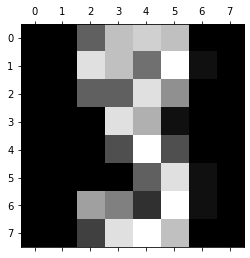

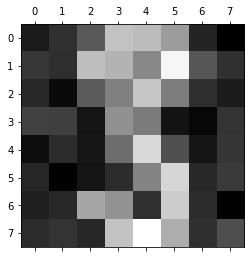

In [23]:
# Example image before and after Gaussian augmentation
img = X_train[0]
plt.matshow(img.reshape(8, 8)) 

img = X_train_gaus[len(X_train)]
plt.matshow(img.reshape(8, 8))
plt.show()

In [24]:
# Gaussian augmentation for perturbed training data
X_train_gaus, y_train_gaus = getGaussianTrain(X_train_adv)
gaussianModel3 = trainSVM(X_train_gaus, y_train_gaus, X_test, y_test)

Accuracy on test examples: 84.72222222222221%


#### 2. Adversarial examples crafted with Jacobian Saliency Method (JS)

Only 100 examples are created and concatenated because they take a long time to generate. We load them from saved .npy files. Generation code can be found in the original notebook on github.

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
dir = '/content/drive/My Drive/ml_project/'

In [27]:
def getJsTrain(X_train, y_train):
    # load the 100 adverse examples
    X_train_jsma = np.load(dir + 'X_train_jsma.npy')
    y_train_jsma = np.load(dir + 'y_train_jsma.npy')

    X_train_jsma = np.concatenate((X_train, X_train_jsma), axis=0)
    y_train_jsma = np.concatenate((y_train, y_train_jsma))
    return X_train_jsma, y_train_jsma

In [28]:
X_train_jsma, y_train_jsma = getJsTrain(X_train, y_train)
modelJs2 = trainSVM(X_train_jsma, y_train_jsma, X_test_adv, y_test)

Accuracy on test examples: 55.833333333333336%


In [29]:
X_train_jsma, y_train_jsma = getJsTrain(X_train_adv, y_train)
modelJs3 = trainSVM(X_train_jsma, y_train_jsma, X_test, y_test)

Accuracy on test examples: 86.11111111111111%


#### 3. Adversarial example crafted with Fast Gradient Method (FG)


In [30]:
def getFsTrain(X_train, y_train):
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=1)
    X_train_fgsm = attack_fgsm.generate(x=X_train_adv)

    X_train_fgsm = np.concatenate((X_train, X_train_fgsm), axis=0)
    y_train_fgsm = np.concatenate((y_train, y_train))
    return X_train_fgsm, y_train_fgsm

In [31]:
X_train_fgsm, y_train_fgsm = getFsTrain(X_train, y_train)
modelFg2 = trainSVM(X_train_fgsm, y_train_fgsm, X_test_adv, y_test)

Accuracy on test examples: 98.88888888888889%


In [32]:
X_train_fgsm, y_train_fgsm = getFsTrain(X_train_adv, y_train)
modelFg3 = trainSVM(X_train_fgsm, y_train_fgsm, X_test, y_test)

Accuracy on test examples: 57.49999999999999%


### Training SVM on attacked data set

Method: Iteratively train SVM on the data set. Each time, based on current 
hypothesis, we remove a certain percent of data and train SVM on the rest of data. Our performance should be comparable to the baseline.

In details: We set up two parameters p and q, the probability for removing a mis-labeled/correctly

In [33]:
import random

def trainSVMiter(X_train,y_train,X_test,y_test,R=10,prop=5):
  X_train_guess=X_train
  y_train_guess=y_train
  for _ in range(R):
  # rank the mis-classified samples and remove some of them. 
    model=SVC(C=1.0, kernel="rbf").fit(X_train_guess, y_train_guess)
    raws=[]
    predictions = model.predict(X_train)
    accuracy = np.sum(predictions == y_train) / len(y_train)
    print("Accuracy on train examples: {}%".format(accuracy * 100))
    for i in range(len(y_train)):
      if predictions[i]!=y_train[i]:
        if random.randint(1, 10)>=prop:
          raws.append(i)
      
      else:
        if random.randint(1, 10)>=7:
          raws.append(i)
      
    X_train_guess=X_train
    y_train_guess=y_train
    X_train_guess=np.delete(X_train_guess,raws,axis=0)
    y_train_guess=np.delete(y_train_guess,raws,axis=0)
  print(X_train_guess.shape)
  predictions = model.predict(X_test)
  accuracy = np.sum(predictions == y_test) / len(y_test)
  print("Accuracy on test examples: {}%".format(accuracy * 100))

trainSVMiter(X_train_adv, y_train, X_test, y_test)

Accuracy on train examples: 99.72164231036882%
Accuracy on train examples: 98.95615866388309%
Accuracy on train examples: 99.02574808629089%
Accuracy on train examples: 99.30410577592205%
Accuracy on train examples: 99.16492693110646%
Accuracy on train examples: 99.02574808629089%
Accuracy on train examples: 99.30410577592205%
Accuracy on train examples: 98.8169798190675%
Accuracy on train examples: 99.16492693110646%
Accuracy on train examples: 98.8169798190675%
(871, 64)
Accuracy on test examples: 69.16666666666667%


This improves upon our baseline3.

## Results

Show tables comparing your methods to the baselines.

What about these results surprised you? Why?

Did your models over- or under-fit? How can you tell? What did you do to address these issues?

What does the evaluation of your trained models tell you about your data? How do you expect these models might behave differently on different data?  

### PCA

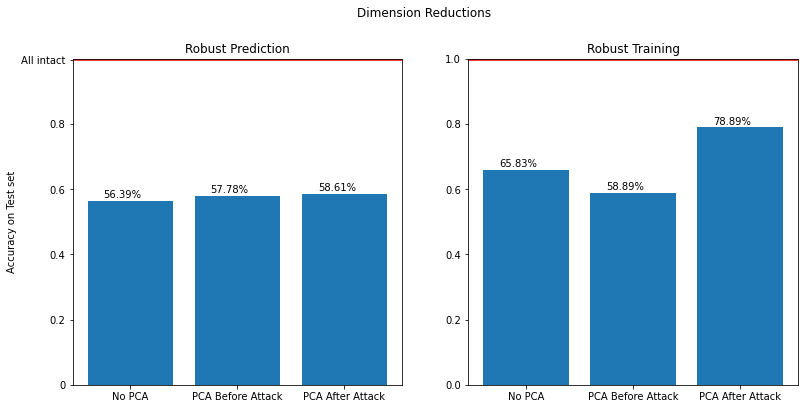

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

x = ['No PCA', 'PCA Before Attack', 'PCA After Attack']
accuracy1_array = [accuracy2, accuracy_pca_test, accuracy_test_PCA]
accuracy2_array = [accuracy3, accuracy_pca_train, accuracy_train_PCA]

x_pos = range(3)

fig, ax = plt.subplots(1,2,figsize=(13,6))

ax[0].bar(x_pos, accuracy1_array)
ax[0].set_xticks(x_pos)
ax[0].set_xticklabels(x)
ax[0].set_ylim([0,1])
ax[0].axhline(y=accuracy1, c='r')
ax[0].set_title("Robust Prediction")
ax[0].set_ylabel("Accuracy on Test set")

ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, accuracy1])
ax[0].set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', 'All intact'])

ax[1].bar(x_pos, accuracy2_array)
ax[1].set_xticks(x_pos)
ax[1].set_xticklabels(x)
ax[1].set_ylim([0,1])
ax[1].axhline(y=accuracy1, c='r')
ax[1].set_title("Robust Training")

for i, pos in enumerate(x_pos):
    ax[0].text(pos-0.25, accuracy1_array[i] + 0.01, f"{accuracy1_array[i]*100:.2f}%")
    ax[1].text(pos-0.25, accuracy2_array[i] + 0.01, f"{accuracy2_array[i]*100:.2f}%")

plt.suptitle("Dimension Reductions", y=1)
plt.show()

### Sharpenining

#### Plot Results Against Baselines

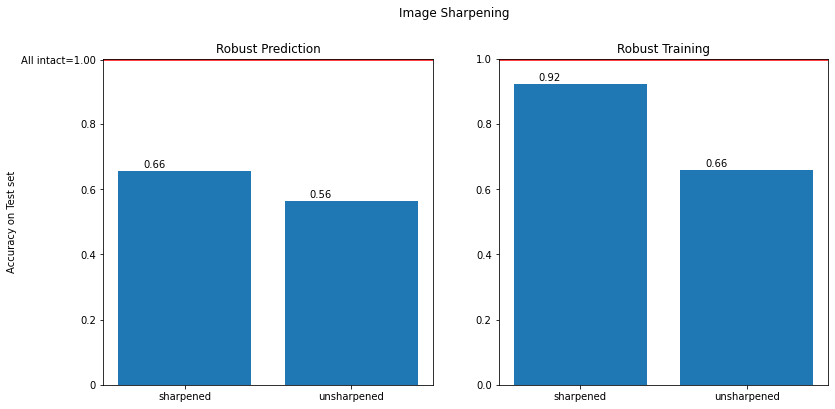

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

x = ['sharpened', 'unsharpened']
accuracy2_array = [accuracy2_sharpen, accuracy2]
accuracy3_array = [accuracy3_sharpen, accuracy3]

x_pos = range(2)

fig, ax = plt.subplots(1,2, figsize=(13,6))

ax[0].bar(x_pos, accuracy2_array)
ax[0].set_xticks(x_pos)
ax[0].set_xticklabels(x)
ax[0].set_ylim([0,1])
ax[0].axhline(y=accuracy1, c='r')
ax[0].set_ylabel("Accuracy on Test set")
ax[0].set_title("Robust Prediction")
ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, accuracy1])
ax[0].set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', 'All intact='+f"{accuracy1:.2f}"])

ax[1].bar(x_pos, accuracy3_array)
ax[1].set_xticks(x_pos)
ax[1].set_xticklabels(x)
ax[1].set_ylim([0,1])
ax[1].axhline(y=accuracy1, c='r')
ax[1].set_title("Robust Training")

for i, pos in enumerate(x_pos):
    ax[0].text(pos-0.25, accuracy2_array[i] + 0.01, f"{accuracy2_array[i]:.2f}")
    ax[1].text(pos-0.25, accuracy3_array[i] + 0.01, f"{accuracy3_array[i]:.2f}")

plt.suptitle("Image Sharpening", y=1)
plt.show()

#### Tune Hyperparameter `Scale`

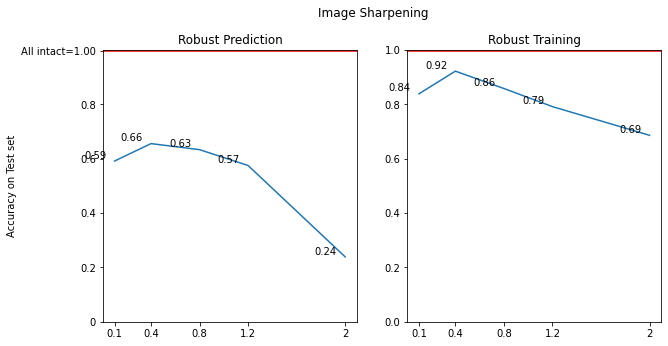

In [36]:
tune_hyperparameter2 = []
tune_hyperparameter3 = []

hyperparam_array = [0.1, 0.4, 0.8, 1.2, 2]

for scale in hyperparam_array:
    # robust testing
    X_test_adv_sharpen = sharpen(X_test_adv, scale=scale)
    y_pred_sharpen = baseline1.predict(X_test_adv_sharpen)
    accuracy2_sharpen = np.sum(y_pred_sharpen == y_test) / len(y_test)

    tune_hyperparameter2.append(accuracy2_sharpen)

    # robust tarining
    X_train_adv_sharpen = sharpen(X_train_adv, scale=scale)

    model_adv_sharpen = SVC(C=1.0, kernel="rbf").fit(X_train_adv_sharpen, y_train)

    y_pred_sharpen = model_adv_sharpen.predict(X_test)
    accuracy3_sharpen = np.sum(y_pred_sharpen == y_test) / len(y_test)

    tune_hyperparameter3.append(accuracy3_sharpen)


fig, ax = plt.subplots(1,2, figsize=(10,5))

x_pos = hyperparam_array

ax[0].plot(x_pos, tune_hyperparameter2)
ax[0].set_xticks(x_pos)
ax[0].set_xticklabels(hyperparam_array)
ax[0].set_ylim([0,1])
ax[0].axhline(y=accuracy1, c='r')
ax[0].set_ylabel("Accuracy on Test set")
ax[0].set_title("Robust Prediction")
ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, accuracy1])
ax[0].set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', 'All intact='+f"{accuracy1:.2f}"])

ax[1].plot(x_pos, tune_hyperparameter3)
ax[1].set_xticks(x_pos)
ax[1].set_xticklabels(hyperparam_array)
ax[1].set_ylim([0,1])
ax[1].axhline(y=accuracy1, c='r')
ax[1].set_title("Robust Training")

for i, pos in enumerate(x_pos):
    ax[0].text(pos-0.25, tune_hyperparameter2[i] + 0.01, f"{tune_hyperparameter2[i]:.2f}")
    ax[1].text(pos-0.25, tune_hyperparameter3[i] + 0.01, f"{tune_hyperparameter3[i]:.2f}")

plt.suptitle("Image Sharpening", y=1)
plt.show()

In [37]:
# Show plots or visualizations of your evaluation metric(s) on the train and test sets.
#   What do these plots show about over- or under-fitting?
#   You may borrow from how we visualized results in the Lab homeworks.
#   Are there aspects of your results that are difficult to visualize? Why?

### Data Augmentation

We can see from the plots that FG (fast gradient with epsilon 1) augmentation does the best on perturbed test data, which is reasonable because the test data is also perturbed with fast gradient method. For robust training (when training data itself is perturbed), Gaussian augmentation does well when epsilon is 3, while JS (Jacobian saliency) and FG does better when epsilon is large.


In [38]:
origAcc = []
gaussianAcc = []
jsAcc = []
fgAcc = []
for eps in range(1, 10):
    X_test_adv_i = fgAttack(X_test, eps)

    predictions = baseline1.predict(X_test_adv_i)
    acc = np.sum(predictions == y_test) / len(y_test)
    origAcc.append(acc)

    predictions = gaussianModel2.predict(X_test_adv_i)
    acc2 = np.sum(predictions == y_test) / len(y_test)
    gaussianAcc.append(acc2)

    predictions = modelJs2.predict(X_test_adv_i)
    acc3 = np.sum(predictions == y_test) / len(y_test)
    jsAcc.append(acc3)

    predictions = modelFg2.predict(X_test_adv_i)
    acc4 = np.sum(predictions == y_test) / len(y_test)
    fgAcc.append(acc4)

Text(0, 0.5, 'Accuracy')

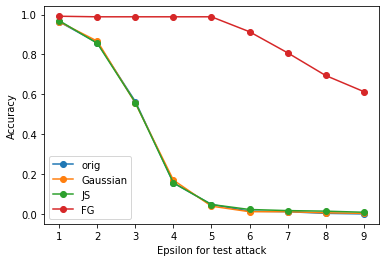

In [39]:
import matplotlib.pyplot as plt

x = range(1, 10)
plt.plot(x, origAcc, '-o', label='orig')
plt.plot(x, gaussianAcc, '-o', label='Gaussian')
plt.plot(x, jsAcc, '-o', label='JS')
plt.plot(x, fgAcc, '-o', label='FG')
plt.legend()
plt.xlabel('Epsilon for test attack')
plt.ylabel('Accuracy')

In [40]:
origAcc2 = []
gaussianAcc2 = []
jsAcc2 = []
fgAcc2 = []
for eps in range(1, 10):
    X_train_adv_i = fgAttack(X_train, eps)
    
    model3 = SVC(C=1.0, kernel="rbf").fit(X_train_adv_i, y_train)
    predictions = model3.predict(X_test)
    acc = np.sum(predictions == y_test) / len(y_test)
    origAcc2.append(acc)

    X_train_gaus, y_train_gaus = getGaussianTrain(X_train_adv_i)
    gaussianModel3 = SVC(C=1.0, kernel="rbf").fit(X_train_gaus, y_train_gaus)
    predictions = gaussianModel3.predict(X_test)
    acc2 = np.sum(predictions == y_test) / len(y_test)
    gaussianAcc2.append(acc2)

    X_train_jsma, y_train_jsma = getJsTrain(X_train_adv_i, y_train)
    modelJs3 = SVC(C=1.0, kernel="rbf").fit(X_train_jsma, y_train_jsma)
    predictions = modelJs3.predict(X_test)
    acc3 = np.sum(predictions == y_test) / len(y_test)
    jsAcc2.append(acc3)

    X_train_fgsm, y_train_fgsm = getFsTrain(X_train_adv_i, y_train)
    modelFg3 = SVC(C=1.0, kernel="rbf").fit(X_train_fgsm, y_train_fgsm)
    predictions = modelFg3.predict(X_test)
    acc4 = np.sum(predictions == y_test) / len(y_test)
    fgAcc2.append(acc4)

Text(0, 0.5, 'Accuracy')

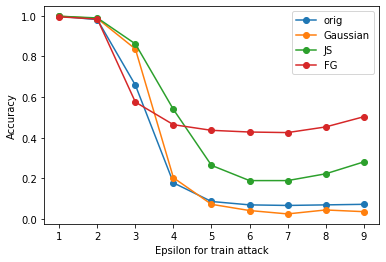

In [41]:
import matplotlib.pyplot as plt

x = range(1, 10)
plt.plot(x, origAcc2, '-o', label='orig')
plt.plot(x, gaussianAcc2, '-o', label='Gaussian')
plt.plot(x, jsAcc2, '-o', label='JS')
plt.plot(x, fgAcc2, '-o', label='FG')
plt.legend()
plt.xlabel('Epsilon for train attack')
plt.ylabel('Accuracy')

# Discussion

## What you've learned

*Note: you don't have to answer all of these, and you can answer other questions if you'd like. We just want you to demonstrate what you've learned from the project.*

What concepts from lecture/breakout were most relevant to your project? How so?

What aspects of your project did you find most surprising?

What lessons did you take from this project that you want to remember for the next ML project you work on? Do you think those lessons would transfer to other datasets and/or models? Why or why not?

What was the most helpful feedback you received during your presentation? Why?

If you had two more weeks to work on this project, what would you do next? Why?

Answer:

Our project is most relevant to the adversarial training portion of the "Practical ML" lecture, since this is the theme we centered around. All methods were tested on support vector machines thus SVM lecture is also closely related to our project. We also used princiapl component analysis to perform a dimensionality reduction, which is connected to the lecture on PCA and the homework 3 lab assignment--the portion on feature selection and noise reduction.

We were surprised how ML algorithms are prone to the effect of adverse examples. But meanwhile, simple approaches may significantly improve the performance (like sharpening, data augmentation, and PCA). Another surprising fact was that blackbox attacks are much harder than whitebox attack. The accuracy actually increased when we tried backdoor attack (blackbox poisoning) on our data.

For future ML projects, we would be more aware of the existence of adverse examples and would be able to apply the above methods to noisy real-world datasets. We believe that the methods we used can generalize to other datasets.

We got a feedback from another group saying that we could try changing p and q values for our iterative learning algorithm during training time, and we think that is a great idea and we would indeed do it if we had time. We could also experiment with different attackers. We could use different attack methods on training and test data, as Prof. Dredze suggested after our presentation. 